# Testing - FastPitch2 + HiFi-GAN


In [10]:
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install -q inflect librosa

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import matplotlib.pyplot as plt

from IPython.display import Audio
import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for inference")

Using cuda for inference


## Load pretrained models


In [2]:
# Download and load the FastPitch model
fastpitch, generator_train_setup = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub", "nvidia_fastpitch"
)

# Download and load the HiFiGAN model
hifigan, vocoder_train_setup, denoiser = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub", "nvidia_hifigan"
)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


HiFi-GAN: Removing weight norm.


In [3]:
CHECKPOINT_SPECIFIC_ARGS = [
    'sampling_rate', 'hop_length', 'win_length', 'p_arpabet', 'text_cleaners',
    'symbol_set', 'max_wav_value', 'prepend_space_to_text',
    'append_space_to_text']

for k in CHECKPOINT_SPECIFIC_ARGS:
    v1 = generator_train_setup.get(k, None)
    v2 = vocoder_train_setup.get(k, None)
    assert v1 is None or v2 is None or v1 == v2, \
        f'{k} mismatch in spectrogram generator and vocoder'


In [6]:
# Put all model to available device
fastpitch.to(device)
hifigan.to(device)
denoiser.to(device)

Denoiser(
  (stft): STFT()
)

## Load text processor

In [7]:
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722 -qO heteronyms
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 -qO cmudict-0.7b

In [11]:
text_processor = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 
                                'nvidia_textprocessing_utils', 
                                cmudict_path="cmudict-0.7b", 
                                heteronyms_path="heteronyms")

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


## Inference 

In [15]:
input_text = "Hello, I am a student from University of Science"
batches = text_processor.prepare_input_sequence([input_text], batch_size=1)

hello, {AY1} am a {S T UW1 D AH0 N T} {F R AH1 M} {Y UW2 N AH0 V ER1 S AH0 T IY0} of {S AY1 AH0 N S}


In [12]:
gen_kw = {
    'pace': 1.0,
    'speaker': 0,
    'pitch_tgt': None,
    'pitch_transform': None
}
denoising_strength = 5e-3

In [16]:
for batch in batches:
    with torch.inference_mode():
        mel, mel_lens, *_ = fastpitch(batch['text'].to(device), **gen_kw)
        audio = hifigan(mel).float()
        audio = denoiser(audio.squeeze(1), denoising_strength)
        audio = audio.squeeze(1) * vocoder_train_setup['max_wav_value']

## Visualize the results

Text(0.5, 1.0, 'Spectrogram')

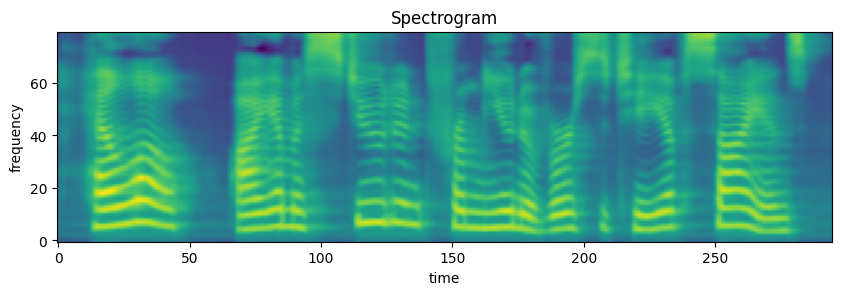

In [17]:
plt.figure(figsize=(10,12))
res_mel = mel[0].detach().cpu().numpy()

plt.imshow(res_mel, origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Spectrogram')

In [18]:
# Syntesize audio
audio_np = audio[0].cpu().numpy()
Audio(audio_np, rate=22050)